In [22]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


# 1) 데이터 준비와 확인

In [23]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2) 데이터로더 구성
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [24]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 중복 제거
    train_data = train_data.dropna(how = 'any') # NaN 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} # 사전 word_to_index 구성
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train)) # 텍스트를 인덱스로 변환
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
      # 최종 리턴값 (X_train, y_train, X_test, y_test, word_to_index)
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [25]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [26]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3) 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [27]:
print(f"훈련 샘플 개수: {len(X_train)}, 테스트 개수: {len(X_test)}")

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [28]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [29]:
import matplotlib.pyplot as plt

# 문장 길이 측정
document_lengths = [len(sentence) for sentence in X_train]

# 통계 수치도 함께 확인
import numpy as np
print("문장 길이 최소값:", np.min(document_lengths))
print("문장 길이 최대값:", np.max(document_lengths))
print("문장 길이 평균값:", np.mean(document_lengths))
print("문장 길이 중간값:", np.median(document_lengths))

# 95% 커버하는 길이 찾기
from collections import Counter

length_counts = Counter(document_lengths)
total = sum(length_counts.values())

sorted_lengths = sorted(length_counts.items())
acc = 0
max_len = 0

for length, count in sorted_lengths:
    acc += count
    if acc / total >= 0.95:  # 누적합이 95% 이상이면 중단
        max_len = length
        break

print(f"95%의 문장을 커버하는 최대 길이: {max_len}")



문장 길이 최소값: 0
문장 길이 최대값: 116
문장 길이 평균값: 15.98170773419436
문장 길이 중간값: 12.0
95%의 문장을 커버하는 최대 길이: 47


In [30]:
# 훈련 + 테스트 데이터를 합쳐 전체 문장 길이 분석
total_data_text = list(X_train) + list(X_test)
num_tokens = np.array([len(tokens) for tokens in total_data_text])

# 평균, 최대, 표준편차 출력
print('문장 길이 평균:', np.mean(num_tokens))
print('문장 길이 최대:', np.max(num_tokens))
print('문장 길이 표준편차:', np.std(num_tokens))

# maxlen 기준 설정
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)

# 얼마나 많은 문장이 이 길이 이내에 포함되는지 확인
ratio = np.sum(num_tokens < max_tokens) / len(num_tokens)
print(f"pad_sequences maxlen: {maxlen}")
print(f"전체 문장의 {ratio * 100:.2f}%가 maxlen 이내에 포함됩니다.")

from tensorflow.keras.preprocessing.sequence import pad_sequences

# word_to_index["<PAD>"] 값이 있는지 확인
pad_index = word_to_index.get("<PAD>")
if pad_index is None:
    word_to_index["<PAD>"] = 0
    pad_index = 0

# 패딩 적용
X_train_padded = pad_sequences(X_train, maxlen=maxlen, padding='post', value=pad_index)
X_test_padded = pad_sequences(X_test, maxlen=maxlen, padding='post', value=pad_index)

print("패딩된 X_train shape:", X_train_padded.shape)
print("패딩된 X_test shape:", X_test_padded.shape)

문장 길이 평균: 15.96940191154864
문장 길이 최대: 116
문장 길이 표준편차: 12.843571191092
pad_sequences maxlen: 41
전체 문장의 93.43%가 maxlen 이내에 포함됩니다.
패딩된 X_train shape: (146182, 41)
패딩된 X_test shape: (49157, 41)


- 숫자 41은 다음 코드 부분에서 설정된 maxlen 값입니다:
- maxlen = int(np.mean(num_tokens) + 2 * np.std(num_tokens))  # 👉 여기서 결정됨
- 즉, 문장 길이의 평균과 표준편차를 바탕으로 대부분의 문장을 포함할 수 있는 적절한 길이로 자동 계산한 값이에요.

# 4) 모델 구성 및 validation set 구성
- 모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [31]:
import tensorflow as tf

# 공통 전처리 및 하이퍼파라미터 설정

vocab_size = 10000        # 단어 사전 크기
word_vector_dim = 16      # 워드 임베딩 차원

In [32]:
#  모델 1: GlobalMaxPooling + Conv1D 기반 모델

model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_length=maxlen))
model1.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model1.add(tf.keras.layers.GlobalMaxPooling1D())
model1.add(tf.keras.layers.Dense(8, activation='relu'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model1.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 16)            160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 161,953
Trainable params: 161,953
Non-trainable params: 0
_________________________________________________________________


In [33]:
# 모델 2: LSTM 기반 모델

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_length=maxlen))
model2.add(tf.keras.layers.LSTM(16))  # 기본 LSTM layer 사용
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model2.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 41, 16)            160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 162,257
Trainable params: 162,257
Non-trainable params: 0
_________________________________________________________________


In [34]:
# 모델 3: RNN(SimpleRNN) 기반 모델

model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_length=maxlen))
model3.add(tf.keras.layers.SimpleRNN(16))  # RNN 셀 사용
model3.add(tf.keras.layers.Dense(8, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model3.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 41, 16)            160000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 16)                528       
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 160,673
Trainable params: 160,673
Non-trainable params: 0
_________________________________________________________________


# 5) 모델 훈련 개시 & # 6) Loss, Accuracy 그래프 시각화

### pad_sequences의 사용
- X_train, X_test, partial_x_train 등의 데이터가 np.array로 되어 있더라도, 그 내부에 여전히 list가 포함되어 있으면 안 됩니다.

In [35]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, maxlen=maxlen, padding='post', value=pad_index)
X_test = pad_sequences(X_test, maxlen=maxlen, padding='post', value=pad_index)

# 명시적으로 np.array 선언 (한 번 더 안전하게)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


# 10,000건을 validation set으로 분리
x_val = X_train[:10000]
y_val = y_train[:10000]

# 나머지를 training set으로 사용
partial_x_train = X_train[10000:]
partial_y_train = y_train[10000:]

In [36]:
import matplotlib.pyplot as plt

# 모델 리스트 정의
def create_models():
    models = []

    # 모델 1: Conv1D + GlobalMaxPooling
    model1 = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_length=maxlen),
        tf.keras.layers.Conv1D(16, 7, activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    models.append(('Conv1D+GlobalMaxPool', model1))

    # 모델 2: LSTM
    model2 = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_length=maxlen),
        tf.keras.layers.LSTM(16),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    models.append(('LSTM', model2))

    # 모델 3: SimpleRNN
    model3 = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_length=maxlen),
        tf.keras.layers.SimpleRNN(16),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    models.append(('SimpleRNN', model3))

    return models



 학습 시작: Conv1D+GlobalMaxPool
Epoch 1/20
266/266 [==============================] - 2s 4ms/step - loss: 0.4830 - accuracy: 0.7808 - val_loss: 0.3519 - val_accuracy: 0.8462
Epoch 2/20
266/266 [==============================] - 1s 4ms/step - loss: 0.3306 - accuracy: 0.8593 - val_loss: 0.3385 - val_accuracy: 0.8512
Epoch 3/20
266/266 [==============================] - 1s 4ms/step - loss: 0.3003 - accuracy: 0.8751 - val_loss: 0.3338 - val_accuracy: 0.8568
Epoch 4/20
266/266 [==============================] - 1s 4ms/step - loss: 0.2778 - accuracy: 0.8864 - val_loss: 0.3377 - val_accuracy: 0.8567
Epoch 5/20
266/266 [==============================] - 1s 4ms/step - loss: 0.2574 - accuracy: 0.8969 - val_loss: 0.3424 - val_accuracy: 0.8559
Epoch 6/20
266/266 [==============================] - 1s 4ms/step - loss: 0.2362 - accuracy: 0.9081 - val_loss: 0.3524 - val_accuracy: 0.8533
Epoch 7/20
266/266 [==============================] - 1s 4ms/step - loss: 0.2136 - accuracy: 0.9191 - val_loss: 0.3695

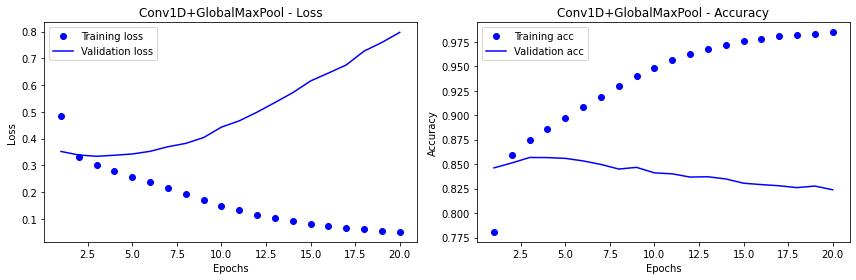


 학습 시작: LSTM
Epoch 1/20
266/266 [==============================] - 3s 8ms/step - loss: 0.5147 - accuracy: 0.7110 - val_loss: 0.3531 - val_accuracy: 0.8482
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3414 - accuracy: 0.8544 - val_loss: 0.3426 - val_accuracy: 0.8518
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3205 - accuracy: 0.8644 - val_loss: 0.3532 - val_accuracy: 0.8500
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3117 - accuracy: 0.8680 - val_loss: 0.3423 - val_accuracy: 0.8492
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3033 - accuracy: 0.8724 - val_loss: 0.3441 - val_accuracy: 0.8472
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2969 - accuracy: 0.8754 - val_loss: 0.3470 - val_accuracy: 0.8509
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2904 - accuracy: 0.8763 - val_loss: 0.3508 - val_accuracy:

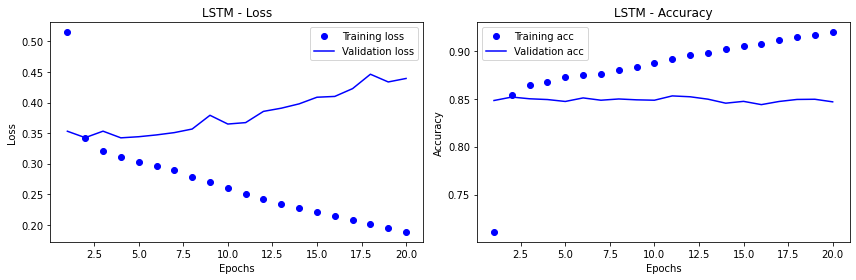


 학습 시작: SimpleRNN
Epoch 1/20
266/266 [==============================] - 10s 35ms/step - loss: 0.5075 - accuracy: 0.7491 - val_loss: 0.4366 - val_accuracy: 0.8093
Epoch 2/20
266/266 [==============================] - 9s 35ms/step - loss: 0.3879 - accuracy: 0.8319 - val_loss: 0.3965 - val_accuracy: 0.8247
Epoch 3/20
266/266 [==============================] - 9s 35ms/step - loss: 0.3564 - accuracy: 0.8485 - val_loss: 0.3909 - val_accuracy: 0.8279
Epoch 4/20
266/266 [==============================] - 9s 34ms/step - loss: 0.3360 - accuracy: 0.8593 - val_loss: 0.3970 - val_accuracy: 0.8304
Epoch 5/20
266/266 [==============================] - 9s 34ms/step - loss: 0.3224 - accuracy: 0.8654 - val_loss: 0.3947 - val_accuracy: 0.8279
Epoch 6/20
266/266 [==============================] - 9s 34ms/step - loss: 0.3081 - accuracy: 0.8724 - val_loss: 0.3993 - val_accuracy: 0.8284
Epoch 7/20
266/266 [==============================] - 9s 34ms/step - loss: 0.2918 - accuracy: 0.8808 - val_loss: 0.4027 - 

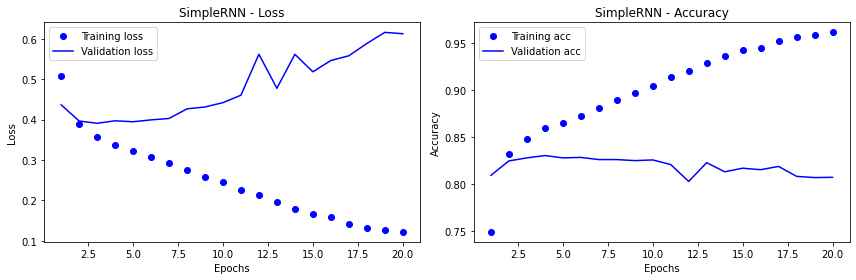

In [37]:
models = create_models()
results_all = []

for model_name, model in models:
    print(f"\n 학습 시작: {model_name}")

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # 모델 학습
    history = model.fit(partial_x_train, partial_y_train,
                        epochs=20,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=1)

    # 테스트 평가
    results = model.evaluate(X_test, y_test, verbose=2)
    results_all.append((model_name, results[0], results[1]))  # (이름, loss, acc)
    
     # 학습 결과 시각화
    history_dict = history.history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs_range = range(1, len(acc) + 1)

    # Loss 그래프
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss, 'bo', label='Training loss')
    plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, acc, 'bo', label='Training acc')
    plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [38]:
import pandas as pd

results_df = pd.DataFrame(results_all, columns=['Model', 'Test Loss', 'Test Accuracy'])
print("\n 모델별 테스트 결과 비교:")
print(results_df)



 모델별 테스트 결과 비교:
                  Model  Test Loss  Test Accuracy
0  Conv1D+GlobalMaxPool   0.816457       0.819598
1                  LSTM   0.448380       0.841874
2             SimpleRNN   0.631211       0.801290


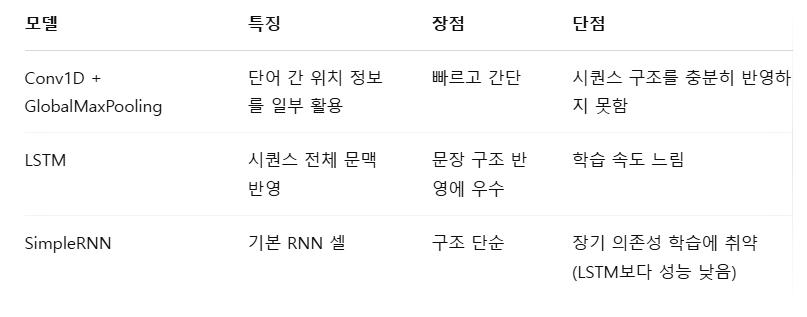

# 7) 학습된 Embedding 레이어 분석


In [43]:
# 1. 학습된 임베딩 가중치 가져오기

embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [44]:
# 2. 학습된 임베딩을 파일로 저장하기
import os
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [45]:
# 3. 저장된 임베딩 불러와 분석하기

from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

# 유사 단어 찾기
similar_words = word_vectors.similar_by_word("사랑", topn=5)
print(similar_words)


[('중독자', 0.9137664437294006), ('~~!!', 0.9012354612350464), ('메마른', 0.8991241455078125), ('^^~', 0.894447922706604), ('정겹', 0.8910658955574036)]


# 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [46]:
from gensim.models import Word2Vec

# 1. 경로 
word2vec_file_path = '/aiffel/data/word2vec_ko.model'

# 2. 모델 불러오기
word2vec_model = Word2Vec.load(word2vec_file_path)

# 3. 벡터 접근을 위해 .wv 사용
word_vectors = word2vec_model.wv

# 4. 단어 벡터 확인
vector = word_vectors["사랑"]
print("벡터 차원:", vector.shape)
print("벡터 값:", vector)

# 5. 유사 단어 찾기
similar_words = word_vectors.most_similar("사랑", topn=5)
print(" 유사한 단어:")
for word, score in similar_words:
    print(f"{word} ({score:.4f})")


벡터 차원: (100,)
벡터 값: [ 3.2565942  -0.85421413 -3.6964011   1.0956469   0.599815   -1.9681435
  0.32379073 -1.0716053  -1.1776937   2.0442047   2.2501915  -2.7868037
 -2.702359   -0.9775915  -0.12478333  0.28235647  0.77683175 -1.5393747
  2.0879042  -5.444462   -4.931412    0.8532094   0.11118065 -2.743522
  0.7902363   0.10469969 -0.56074625  1.6684421   1.0278419  -3.8816829
 -3.606887   -3.120771   -1.2527398  -0.77196646 -1.0102901   3.331668
  0.30032924  1.2074511  -1.2813627   2.6281219  -1.4624823  -1.1354805
  0.7605239   2.83577    -1.199358    3.1347232   4.062026   -0.23413125
  3.205856   -0.9567054   0.77167803 -1.4300145   2.9014013  -3.940087
 -3.234169   -5.5460634   0.6185009  -0.75793767  2.1043491   2.350599
  2.9313247  -2.235593    3.2084036  -5.594638    1.6516634  -0.32628602
 -1.8824683  -1.5573231  -1.8452163  -1.4044309   4.872565   -2.1063929
 -0.32347348  1.9946551  -4.0967984  -1.4509655  -0.09111219 -4.458617
  0.06598099 -2.211754    3.0731246  -0.0691011

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# 1. 정확한 vocab_size 계산
vocab_size = max(word_to_index.values()) + 1
embedding_dim = 100


# 2. Word2Vec 벡터를 embedding_matrix로 매핑
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_to_index.items():
    if i < vocab_size and word in word_vectors:
        embedding_matrix[i] = word_vectors[word]

# 3. Embedding Layer 구성
embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=False)
# trainable=False이면 word2vec 벡터를 고정해서 사용하는 것이고,
# trainable=True로 바꾸면 **미세조정(fine-tuning)**을 하게 됩니다.

# 4. 모델 정의 (LSTM 기반 예시)
model_w2v = Sequential()
model_w2v.add(embedding_layer)
model_w2v.add(LSTM(64))  # 조금 더 표현력 있는 모델
model_w2v.add(Dense(1, activation='sigmoid'))

# 5. 컴파일 및 학습
model_w2v.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_w2v.summary()

# 6. 훈련
history = model_w2v.fit(partial_x_train, partial_y_train,
                        epochs=10,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=1)

# 7. 평가
loss, acc = model_w2v.evaluate(X_test, y_test, verbose=2)
print(f"\n Word2Vec 적용 모델 정확도: {acc * 100:.2f}%")

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 65        
Total params: 1,042,305
Trainable params: 42,305
Non-trainable params: 1,000,000
_________________________________________________________________
Epoch 1/10
266/266 [==============================] - 3s 7ms/step - loss: 0.5064 - accuracy: 0.7461 - val_loss: 0.4376 - val_accuracy: 0.7948
Epoch 2/10
266/266 [==============================] - 1s 5ms/step - loss: 0.4129 - accuracy: 0.8124 - val_loss: 0.3987 - val_accuracy: 0.8194
Epoch 3/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3827 - a

In [52]:
from tensorflow.keras.layers import Bidirectional

# 1. 정확한 vocab_size 계산
vocab_size = max(word_to_index.values()) + 1
embedding_dim = 100


# 2. Word2Vec 벡터를 embedding_matrix로 매핑
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_to_index.items():
    if i < vocab_size and word in word_vectors:
        embedding_matrix[i] = word_vectors[word]

# 3. Embedding Layer 구성
embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                           trainable=True)                # 미세조정 허용


# 4. 모델 정의 (LSTM 기반 예시)
model_w2v = Sequential()
model_w2v.add(embedding_layer)
model_w2v.add(Bidirectional(LSTM(64)))                    # 양방향
model_w2v.add(Dense(1, activation='sigmoid'))

# 5. 컴파일 및 학습
model_w2v.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_w2v.summary()

# 6. 훈련
history = model_w2v.fit(partial_x_train, partial_y_train,
                        epochs=10,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=1)

# 7. 평가
loss, acc = model_w2v.evaluate(X_test, y_test, verbose=2)
print(f"\n Word2Vec 적용 모델 정확도: {acc * 100:.2f}%")

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 129       
Total params: 1,084,609
Trainable params: 1,084,609
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
266/266 [==============================] - 6s 13ms/step - loss: 0.4610 - accuracy: 0.7776 - val_loss: 0.3724 - val_accuracy: 0.8339
Epoch 2/10
266/266 [==============================] - 3s 11ms/step - loss: 0.3420 - accuracy: 0.8504 - val_loss: 0.3334 - val_accuracy: 0.8562
Epoch 3/10
266/266 [==============================] - 3s 11ms/step - loss: 0.2982 - acc

- [1] Bidirectional LSTM 적용
- [2] Fine-tuning (trainable=True) 으로 임베딩 조정 허용
- Word2Vec + BiLSTM + Fine-tuning